# Logistic Regression

## Reading the data

In [7]:
import pandas as pd
import numpy as np
import torch
import os
import multiprocessing as mp
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce


In [27]:

filepath = '/workspaces/eng-ai-agents/assignments/assignment-1/data/train.gz'

# using smaller sample size due to ram issue
sample_size = 2000000

# Read training data
dataset = pd.read_csv(filepath, nrows=sample_size)

dataset.head()
    

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157


## Correlation map  

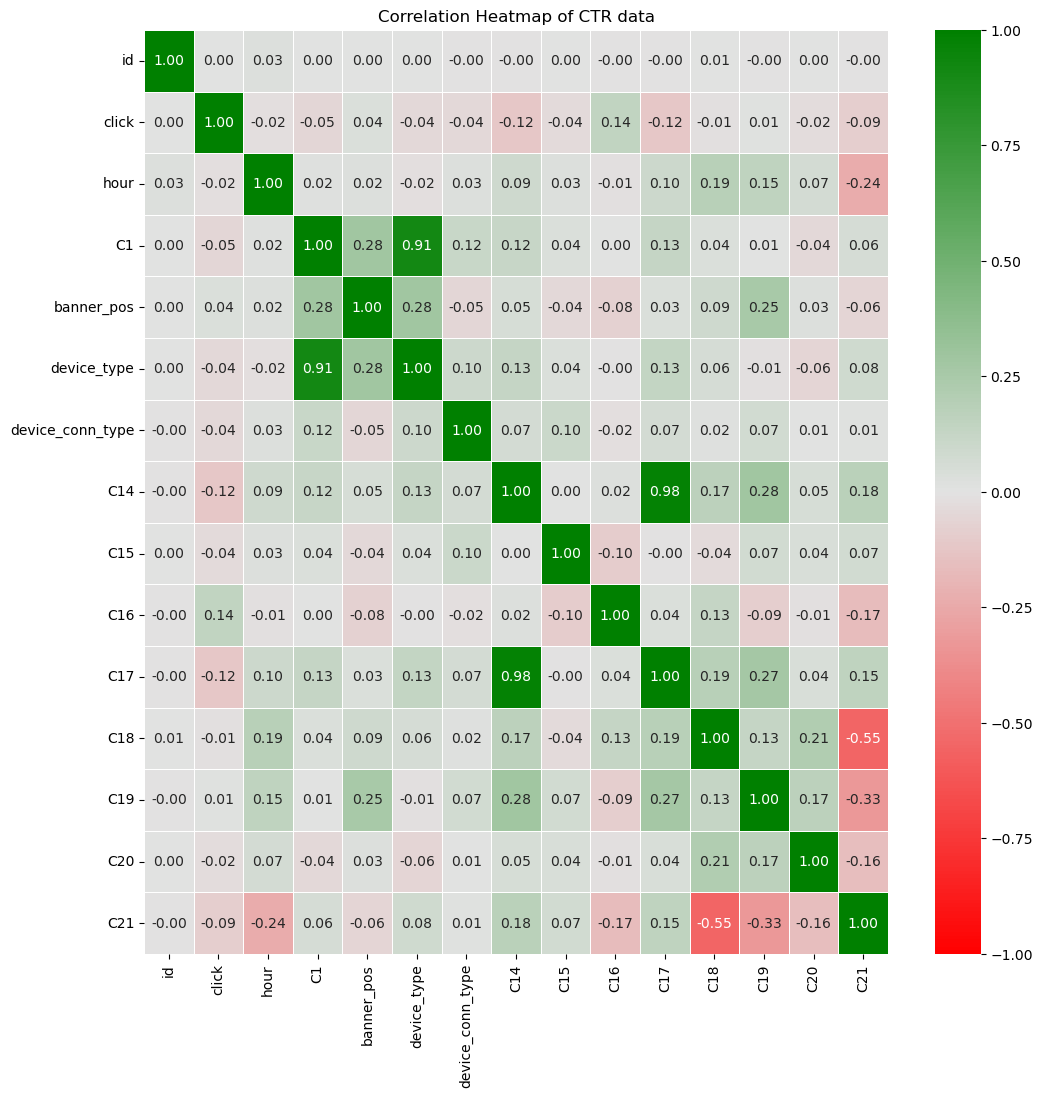

In [3]:
#Correlation
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# Define custom colors for the colormap
colors = ["red", "#e2e2e2", "green"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_rg", colors)

# Calculate the correlation matrix
corr = dataset.corr( numeric_only=True)

# Create a heatmap using the custom colormap and setting color range
plt.figure(figsize=(12, 12))
sns.heatmap(corr, annot=True, cmap=custom_cmap, fmt=".2f", linewidths=0.5, cbar=True, vmin=-1, vmax=1)
plt.title('Correlation Heatmap of CTR data')
plt.show()

In [4]:
dataset.nunique()

id                  500000
click                    2
hour                     4
C1                       7
banner_pos               6
site_id               1704
site_domain           1586
site_category           21
app_id                1641
app_domain             122
app_category            20
device_id            41413
device_ip           171304
device_model          3967
device_type              4
device_conn_type         4
C14                    540
C15                      8
C16                      9
C17                    154
C18                      4
C19                     40
C20                    154
C21                     34
dtype: int64

## Data cleaning

* Using minimal features due to the curse of dimensionality. 
* Using one hot encoding for categorical data 

In [28]:

# Using minimal features due to curse of dimensionality 
features = ['click', 'banner_pos', 'device_type', 'device_conn_type', 'site_category', 'app_category', 'app_domain', 'device_model', 'C1', 'C16']
unused = ['id', 'click', 'hour', 'device_id', 'device_ip']

X = dataset.drop(columns=unused)
y = dataset['click']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


low_cardinality_cols = [
    'C1', 'banner_pos', 'site_category', 'app_category', 'app_domain', 
    'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C19', 'C21'
]

high_cardinality_cols = [
    'site_id', 'site_domain', 'app_id', 'device_model', 'C14', 'C17', 'C20'
]

# This applies the correct transformer to each group of columns
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), low_cardinality_cols),
        ('hashing', ce.HashingEncoder(n_components=100), high_cardinality_cols)
    ],
    remainder='passthrough' # Leave other columns (if any) untouched
)

for col in high_cardinality_cols:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)
    
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("processed training data:", X_train_processed.shape)
print("processed testing data:", X_test_processed.shape)

processed training data: (1600000, 469)
processed testing data: (400000, 469)


In [9]:
# check if there are any null values
dataset.isnull().sum()

id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
dtype: int64

# Logistic regression



### Initializing parameters  

1. Split dataset dataframe to pytorch tensors x_tensor and y_tensor  
    * `X_tensor`, training features
    * `Y_tensor`, true labels 
2. `W`, vector is the weight vector 
3. `b`, is the bias 
4. `n`, learning rate, which is a small positive number that controls the step size

In [33]:

# Convert the split data into PyTorch Tensors
X_train_tensor = torch.tensor(X_train_processed.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)

X_test_tensor = torch.tensor(X_test_processed.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

# Weight vector 
w = torch.zeros(X_train_processed.shape[1])
print(w)

# bias
b = 0

# Learning rate
n = 0.01

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

## Training
### Forward Pass

* Calculating the logit ($z$) by using the linear equation:
    $$z_i = \mathbf{w^T} \cdot \mathbf{x_i} + b$$

* Calculating the predicted probability ($\hat{y}$) by squashing the logit to a value between 0 and 1 using the sigmoid function:
    $$\hat{y_i} = \sigma(z) = \frac{1}{1 + e^{-z_i}}$$

### Backward Pass

* Calculate the gradients of the Binary Cross-Entropy Loss. These gradients tell us the direction and magnitude of the error, so we know how to update our parameters.
    * Gradient with respect to bias ($b$): This is the simple difference between the predicted probability and the true label.
        $$ \frac{\partial L}{\partial b} = \hat{y_i} - y_i $$
    * Gradient with respect to weights ($\mathbf{w}$): This is the prediction error, scaled by the input feature vector $\mathbf{x}$.
        $$ \frac{\partial L}{\partial \mathbf{w}} = (\hat{y_i} - y_i) \mathbf{x_i} $$

* Use the  gradients to take a small step in the opposite direction of the error and adjusts the models parameters to improve the precision. The size of the step is controlled by the learning rate ($\eta$).
    * Update the weights ($\mathbf{w}$):
        $$ \mathbf{w} := \mathbf{w} - \eta \cdot \frac{\partial L}{\partial \mathbf{w}} $$

    * Update the bias ($b$):
        $$ b := b - \eta \cdot \frac{\partial L}{\partial b} $$

### Single core Implementation

In [38]:

num_epochs = 5
# Main logistic regression loop epoch = 1
for epoch in range(num_epochs):
    # Loops through each sample in dataset
    for i in range(len(X_train_tensor)):
        Xi = X_train_tensor[i]
        Yi = y_train_tensor[i]
        #calculate logit for matrix multiplication using @ operator
        logit = (Xi @ w) + b
        
        # Get y for sigmoid function
        Yhat = 1/(1 + torch.exp(-logit))
        
        # backward pass calculate gradients
        gradient_b = Yhat - Yi
        gradient_w = (Yhat - Yi) * Xi
        
        # Update the parameters 
        b -= n * gradient_b
        w -= n * gradient_w



torch.save({
    'weights': w,
    'bias': b,
}, 'final_logistic_regression_model.pth')

print(w)
print(b)
        

tensor([ 4.6694e-02,  1.5327e-01,  1.7650e-01,  2.1860e-01, -1.9544e-01,
        -3.7214e-01, -7.4950e-01, -5.7499e-01, -5.4516e-02,  4.2530e-01,
        -1.1510e-02, -1.3888e-01, -1.9544e-01, -1.7198e-01, -1.3448e+00,
         4.8161e-01,  9.3408e-02,  4.0164e-01,  2.3864e-02, -8.2531e-02,
        -1.2866e-01,  1.7410e+00,  4.9436e-01, -1.6854e-02,  9.7682e-01,
        -4.1675e-01,  6.5451e-02, -1.9264e-02, -2.8235e+00,  2.8735e-01,
        -4.2373e-01,  2.4406e-01,  2.1443e-01,  3.3736e-01, -8.2731e-01,
         3.3382e-01, -1.3445e-01, -4.9733e-02,  2.4610e-01, -1.9980e-02,
        -1.1068e-02, -1.6350e-01, -1.3881e-03,  1.5347e-01, -1.6822e-03,
         1.1042e-01, -2.1381e-03,  1.7135e-02, -3.2380e-02,  2.8406e-02,
        -1.5597e-02,  7.9577e-02, -4.5225e-01, -2.2719e-02, -1.5744e-02,
         2.9074e-03,  3.2867e-01, -5.4268e-01,  4.3432e-02,  7.0951e-01,
         3.0649e-01, -1.6168e+00, -2.4779e-03, -4.0234e-03,  3.2684e-02,
         1.3542e+00, -2.2367e-02, -2.8285e-01,  3.9

## Performance upgrades (ignore)

Implemented parallel programming due to the training being extremely slow and taking 12 minutes for one epoch (ignore this)

In [23]:

def train_worker(data):
    """A function that runs the SGD loop for one worker."""
    
    torch.manual_seed(os.getpid())
    
    X, y = data
    n_features = X.shape[1]

    # Each worker gets its own model
    w = torch.randn(n_features, 1) * 0.01
    
    print(f"Worker PID {os.getpid()}: Initial weight sum = {w.sum()}")
    
    b = torch.zeros(1)
    total_loss = 0.0
    log_interval = 50000  # Print status every 50,000 samples

    learning_rate = 0.1
    num_epochs = 1  # Train for a reasonable number of epochs
    for epoch in range(num_epochs):
        # Loops through each sample in dataset
        for i in range(len(X_train_tensor)):
            Xi = X[i]
            Yi = y[i]
            # calculate logit for matrix multiplication using @ operator
            logit = (Xi @ w) + b

            # Get y for sigmoid function
            y_hat = 1 / (1 + torch.exp(-logit))

            # --- Calculate Loss (FOR DEBUGGING) ---
            # Add a small epsilon to prevent log(0) which results in NaN
            epsilon = 1e-7
            loss = -(Yi * torch.log(y_hat + epsilon) + (1 - Yi) * torch.log(1 - y_hat + epsilon))
            total_loss += loss.item()

            # backward pass calculate gradients
            gradient_b = y_hat - Yi
            gradient_w = (y_hat - Yi) * Xi.view(-1, 1)

            # Update the parameters
            with torch.no_grad():
                b -= learning_rate * gradient_b
                w -= learning_rate * gradient_w

            if (i + 1) % log_interval == 0:
                avg_loss = total_loss / log_interval
                print(f"Sample [{i + 1}/{len(X_train_tensor)}], Avg Loss: {avg_loss:.6f}")
                # Print the average magnitude of your gradients
                print(f"  Avg Gradient Magnitude (bias): {gradient_b.abs().mean():.6f}")
                print(f"  Avg Gradient Magnitude (weights): {gradient_w.abs().mean():.6f}\n")
                total_loss = 0.0  # Reset loss accumulator

    return w, b


if __name__ == "__main__":
    num_workers = 12  # Set to the number of cores you want to use

    # Create a pool of worker processes
    pool = mp.Pool(num_workers)

    # Run the train_worker function in parallel
    # Each worker gets the full dataset
    results = pool.map(train_worker, [(X_train_tensor, y_train_tensor)] * num_workers)

    pool.close()
    pool.join()

    # --- Average the results ---
    all_weights = [res[0] for res in results]
    all_biases = [res[1] for res in results]

    # Stack tensors and calculate the mean
    final_w = torch.stack(all_weights).mean(axis=0)
    final_b = torch.stack(all_biases).mean(axis=0)

    print("Final averaged weights shape:", final_w.shape)

Worker PID 8874: Initial weight sum = -0.20387500524520874Worker PID 8873: Initial weight sum = -0.26109379529953003Worker PID 8870: Initial weight sum = -0.20603051781654358Worker PID 8877: Initial weight sum = -0.30004602670669556Worker PID 8868: Initial weight sum = -0.12532314658164978Worker PID 8871: Initial weight sum = -0.17455929517745972Worker PID 8875: Initial weight sum = 0.3430006206035614Worker PID 8872: Initial weight sum = 0.08711308240890503Worker PID 8876: Initial weight sum = -0.21671664714813232Worker PID 8866: Initial weight sum = -0.07953377813100815Worker PID 8867: Initial weight sum = 0.11220991611480713Worker PID 8869: Initial weight sum = 0.4739779233932495











Sample [50000/400000], Avg Loss: 0.471141
  Avg Gradient Magnitude (bias): 0.213214
  Avg Gradient Magnitude (weights): 0.011099

Sample [50000/400000], Avg Loss: 0.471154
  Avg Gradient Magnitude (bias): 0.213242
  Avg Gradient Magnitude (weights): 0.011100

Sample [50000/400000], Avg Loss: 0.471

# Testing Model



In [39]:
# Load data from final 
model = torch.load('final_logistic_regression_model.pth')

w = model['weights']
b = model['bias']

with torch.no_grad(): 
    # Get the raw logit scores
    logits = X_test_tensor @ w + b
    
    # Convert logits to probabilities
    y_probabilities = torch.sigmoid(logits)

#converts probablities to 0 or 1 based on if its higher then or lower than 0.5 and converts it to floats
y_predictions = (y_probabilities >= 0.5).float()



/tmp/ipykernel_6800/4170333395.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('final_logistic_regression_model.pth')


In [40]:
# Convert to numpy arrays for sklearn metrics
y_true_numpy = y_test_tensor.cpu().numpy()
y_pred_numpy = y_predictions.cpu().numpy()

# Calculated metrics for the model 
accuracy = accuracy_score(y_true_numpy, y_pred_numpy)
precision = precision_score(y_true_numpy, y_pred_numpy)
recall = recall_score(y_true_numpy, y_pred_numpy)
f1 = f1_score(y_true_numpy, y_pred_numpy)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")




Accuracy: 0.8389
Precision: 0.5058
Recall: 0.1231
F1-Score: 0.1981


# Precision vs recall graph

* The tradeoff between precision and recall is to find more true positives, which means increasing recall you must typically accept making more false positive errors which is decreasing precision 
* This inverse relationship is controlled by the model's decision threshold, which is the cutoff score you use to classify a prediction as positive or negative and is what gives the Precision-Recall curve its characteristic shape.

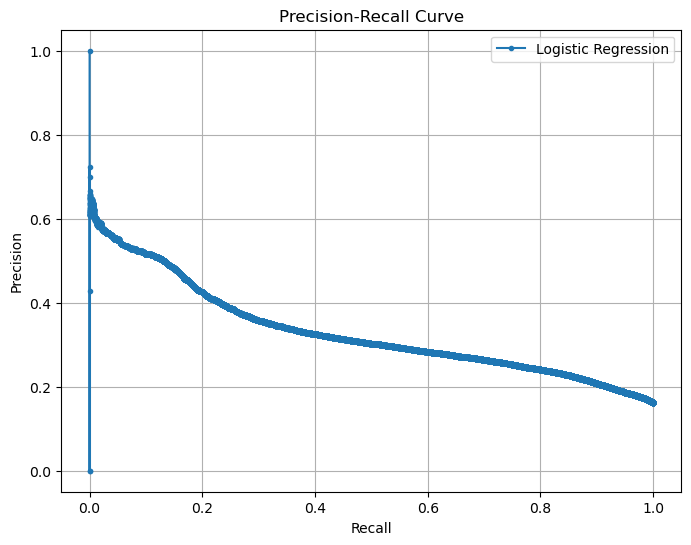

In [42]:

precision, recall, thresholds = precision_recall_curve(y_true_numpy, y_probabilities)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Logistic Regression')

# Add labels and a title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()
